In [1]:
## %matplotlib inline
import sys 
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import os


from pymcmcstat import propagation as up
from pymcmcstat.MCMC import MCMC
from pymcmcstat.plotting import MCMCPlotting
import pymcmcstat
print(pymcmcstat.__version__)
np.seterr(over='ignore');
from lmfit import  Parameters, Parameter

import pandas as pd 
import csv as csv 
import math as math

import scipy.stats as stat
from scipy import interpolate 
from scipy.stats import gamma, poisson

#from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

import seaborn as sns # Figure

import datetime as dt
import dateutil as dateutil

import epyestim
import epyestim.covid19 as covid19


plt.style.use('seaborn-white')
sns.set_context("talk")


1.9.0


In [2]:
## Repertoire de travail
dirName='/home/slimane/como-master/analyseTN/simulationDonneeTN5000/rapport19Jui_LitHop/' 
os.chdir(dirName)

In [3]:
# WHO data
def import_dataWHO(index = 'Tunisia'):
    #importing global data
    url="https://covid19.who.int/WHO-COVID-19-global-data.csv"
    data = pd.read_csv(url, error_bad_lines=False)
   

    
    who_tn_data=data.loc[data.Country==index]
    who_tn_data.drop(["Country","Country_code","WHO_region"],axis=1,inplace=True)
    
    who_tn_data.Date_reported=pd.to_datetime(who_tn_data.Date_reported)    
    who_tn_data.rename(columns={"Date_reported":"date"},inplace=True)

    who_tn_data.set_index("date",inplace=True,drop=True)
    who_tn_data=who_tn_data.reindex(dti)
    
    return who_tn_data

In [4]:
#moyenne mouvente sur 7 jours
from astropy.convolution import convolve, Box1DKernel

def dataFit(data, N=6,m=6):
    #tn['fittedNewCases1']=tn.New_cases.rolling(window=4).mean()
    ddata=data 
    for i in np.arange(m):
        smooth_dataNewCase1=convolve(ddata,kernel=Box1DKernel(N), boundary='extend')
        ddata=smooth_dataNewCase1
    

    fig, ax = plt.subplots(figsize=(15,7))
    plt.plot(data)
    plt.plot(ddata, color='red', label='fitted data')
    #plt.plot(np.arange(len(ddata)),pd.DataFrame.rolling(tn.newCase[:todayDate],7).mean(),color='green')
    plt.plot(ddata,label='raw data')
    plt.ylabel('New cases')
    ax.legend()
    return ddata


In [5]:
PopNumber=1e5/11818619
# Début et fin de l'étude 

#today=dt.datetime.today().strftime('%Y-%m-%d')

todayDate=dt.datetime.today()-pd.Timedelta(1, unit='d') # les donnees ont tj un jour de retard 
beginDate=pd.to_datetime('2020-1-1')
endDate=pd.to_datetime('2022-7-1')
#typ="IntensiteConf"

dti = pd.date_range(start=beginDate, end=endDate, freq='D')



# Case and death database

In [6]:
tn= import_dataWHO('Tunisia')
tn.head()


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
2020-01-01,NaN,NaN,NaN,NaN
2020-01-02,NaN,NaN,NaN,NaN
2020-01-03,0.0,0.0,0.0,0.0
2020-01-04,0.0,0.0,0.0,0.0
2020-01-05,0.0,0.0,0.0,0.0


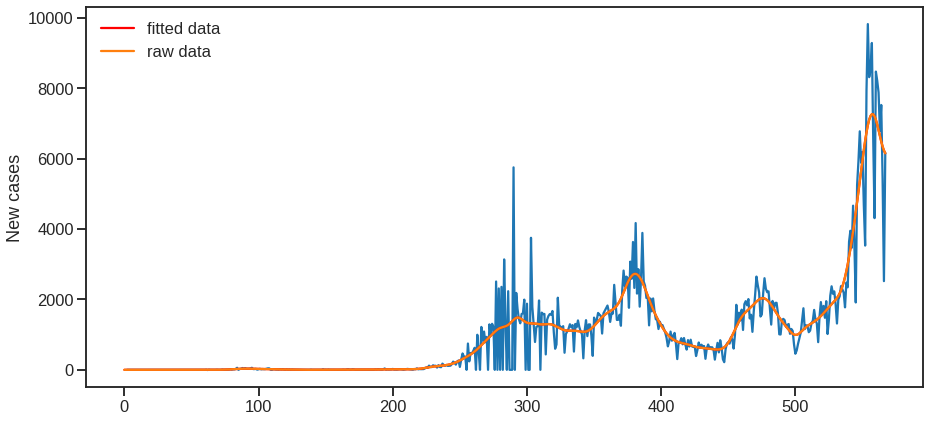

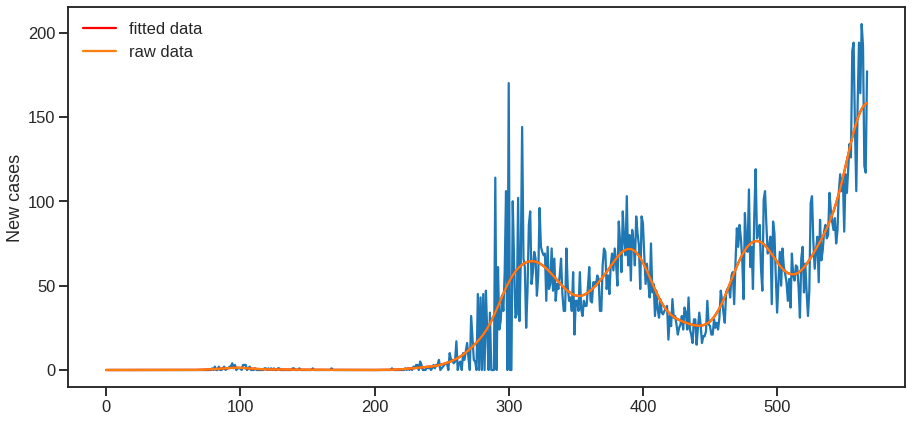

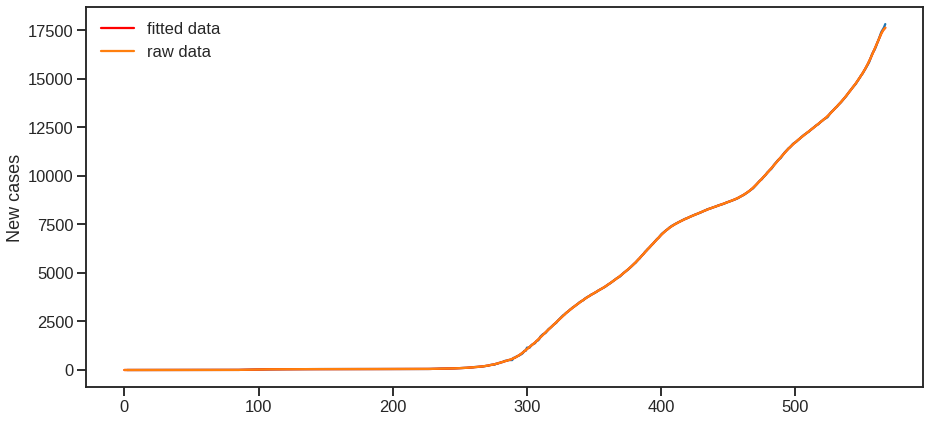

In [7]:
nday=len(tn[:todayDate])
smooth_dataNewCase=dataFit(np.array(tn.New_cases[:nday]), N=6,m=6)
smooth_dataNewDeath=dataFit(np.array(tn.New_deaths[:nday]), N=6,m=20)
smooth_dataDeath=dataFit(np.array(tn.Cumulative_deaths[:nday]), N=6,m=2)
tn['fittedNewCasesSMA']=np.append(smooth_dataNewCase ,np.nan*np.ones(len(tn)-nday))
tn['fittedNewDeathSMA']=np.append(smooth_dataNewDeath ,np.nan*np.ones(len(tn)-nday))
tn['fittedDeathSMA']=np.append(smooth_dataDeath ,np.nan*np.ones(len(tn)-nday))


# Bed occupancy database

In [8]:
xls = pd.ExcelFile('/home/slimane/como-master/analyseTN/litHopital/Hopit_Clin.xlsx')
ddf = pd.read_excel(xls, 'Hopitaux')


In [9]:
ddf

,Date,Gov,Struct,INDEX,lits_rea,lits_rea_occ,lits_rea_disp,lits_o2,lits_o2_occ,lits_o2_disp,z_tamp
0,01-01-2021,Tunis,HÔPITAL HABIB THAMEUR,HU6,12,12,0,27,19,8,0
1,01-01-2021,Tunis,HCN,HC108,13,13,0,64,47,17,0
2,01-01-2021,Tunis,LA RABTA,HU16,12,12,0,105,24,81,7
3,01-01-2021,Tunis,HÔPITAL MONGI SLIM,HU9,12,12,0,26,26,0,0
4,01-01-2021,Tunis,HÔPITAL MILITAIRE PRINCIPALE D'INSTRUCTION DE ...,HM1,17,17,0,50,33,17,8
...,...,...,...,...,...,...,...,...,...,...,...
31981,31-05-2021,Medenine,HR DE BEN GUERDANE,HR7,0,0,0,6,6,0,0
31982,31-05-2021,Medenine,HC BANI KHEDACH,HC7,0,0,0,2,0,2,2
31983,31-05-2021,Tataouine,HR DE TATAOUINE,HR17,4,3,1,14,4,10,0
31984,31-05-2021,Tataouine,HC GHOMRASSEN,HC41,0,0,0,6,0,6,0


In [10]:
np.where(pd.isnull(ddf))

(array([11146, 12280, 13414, 14548, 15682, 16816, 17950, 19084]),
 array([3, 3, 3, 3, 3, 3, 3, 3]))

In [11]:
ddf[ddf.index.duplicated()]

,Date,Gov,Struct,INDEX,lits_rea,lits_rea_occ,lits_rea_disp,lits_o2,lits_o2_occ,lits_o2_disp,z_tamp


In [12]:
ddf['Date'] = ddf['Date'].apply(dateutil.parser.parse, dayfirst=True)
ddf.rename(columns={"Date":"date"},inplace=True)

    
ddf['Gov'] = ddf['Gov'].astype('category')
ddf['Struct'] = ddf['Struct'].astype('category')

In [13]:
ddf.tail()

,date,Gov,Struct,INDEX,lits_rea,lits_rea_occ,lits_rea_disp,lits_o2,lits_o2_occ,lits_o2_disp,z_tamp
31981,2021-05-31,Medenine,HR DE BEN GUERDANE,HR7,0,0,0,6,6,0,0
31982,2021-05-31,Medenine,HC BANI KHEDACH,HC7,0,0,0,2,0,2,2
31983,2021-05-31,Tataouine,HR DE TATAOUINE,HR17,4,3,1,14,4,10,0
31984,2021-05-31,Tataouine,HC GHOMRASSEN,HC41,0,0,0,6,0,6,0
31985,2021-05-31,Tataouine,HC REMADA,HC85,0,0,0,4,0,4,0


In [14]:
max(ddf['date'])

Timestamp('2021-07-17 00:00:00')

In [15]:
 ddf.index[ddf.applymap(np.isreal).lits_o2_occ==False]

Int64Index([], dtype='int64')

In [16]:
 ddf.index[ddf.lits_o2<0]

Int64Index([], dtype='int64')

In [17]:
ddf.groupby(by=['date','Gov'])

In [18]:
ddf['Gov'].unique()

['Tunis', 'Manouba', 'Ariana', 'Ben Arous', 'Zaghouan', ..., 'Tozeur', 'Kebili', 'Gabes', 'Medenine', 'Tataouine']
Length: 24
Categories (24, object): ['Tunis', 'Manouba', 'Ariana', 'Ben Arous', ..., 'Kebili', 'Gabes', 'Medenine', 'Tataouine']

In [19]:
ddf.describe()

,lits_rea,lits_rea_occ,lits_rea_disp,lits_o2,lits_o2_occ,lits_o2_disp,z_tamp
count,31986.000000,31986.000000,31986.000000,31986.000000,31986.000000,31986.000000,31986.000000
mean,2.292659,1.864378,0.428281,13.619646,7.640624,5.978834,0.886607
std,5.550855,4.863565,1.508581,22.034674,16.636186,10.133081,3.156200
min,0.000000,0.000000,-12.000000,0.000000,0.000000,-37.000000,0.000000
25%,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,6.000000,2.000000,3.000000,0.000000
75%,0.000000,0.000000,0.000000,13.000000,7.000000,7.000000,0.000000
max,63.000000,60.000000,20.000000,200.000000,191.000000,116.000000,50.000000


### Database Regionale 

In [20]:
df_Reg = pd.DataFrame(ddf.groupby(by=['date','Gov']).sum())
df_Reg.reset_index(level=[0,1], inplace=True)
df_Reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4752 entries, 0 to 4751
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           4752 non-null   datetime64[ns]
 1   Gov            4752 non-null   category      
 2   lits_rea       4740 non-null   float64       
 3   lits_rea_occ   4740 non-null   float64       
 4   lits_rea_disp  4740 non-null   float64       
 5   lits_o2        4740 non-null   float64       
 6   lits_o2_occ    4740 non-null   float64       
 7   lits_o2_disp   4740 non-null   float64       
 8   z_tamp         4740 non-null   float64       
dtypes: category(1), datetime64[ns](1), float64(7)
memory usage: 302.6 KB


In [21]:
df_Reg

,date,Gov,lits_rea,lits_rea_occ,lits_rea_disp,lits_o2,lits_o2_occ,lits_o2_disp,z_tamp
0,2021-01-01,Ariana,21.0,17.0,4.0,126.0,65.0,61.0,0.0
1,2021-01-01,Ben Arous,8.0,7.0,1.0,37.0,18.0,19.0,0.0
2,2021-01-01,Bizerte,14.0,3.0,11.0,145.0,37.0,108.0,14.0
3,2021-01-01,Béja,2.0,2.0,0.0,39.0,13.0,26.0,0.0
4,2021-01-01,Gabes,10.0,3.0,7.0,46.0,40.0,6.0,1.0
...,...,...,...,...,...,...,...,...,...
4747,2021-07-17,Sousse,49.0,58.0,-9.0,239.0,214.0,25.0,8.0
4748,2021-07-17,Tataouine,6.0,10.0,-4.0,69.0,39.0,30.0,0.0
4749,2021-07-17,Tozeur,5.0,4.0,1.0,48.0,20.0,28.0,4.0
4750,2021-07-17,Tunis,130.0,125.0,5.0,659.0,598.0,61.0,19.0


### Database nationale 

In [22]:
df_Nat = pd.DataFrame(ddf.groupby(['date']).sum())
#df_Nat.set_index('date', inplace=True,drop=True)
df_Nat=df_Nat.reindex(dti)
df_Nat.head()

,lits_rea,lits_rea_occ,lits_rea_disp,lits_o2,lits_o2_occ,lits_o2_disp,z_tamp
2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
df_Nat.dropna().tail()

,lits_rea,lits_rea_occ,lits_rea_disp,lits_o2,lits_o2_occ,lits_o2_disp,z_tamp
2021-07-13,534.0,499.0,35.0,3171.0,2758.0,413.0,398.0
2021-07-14,535.0,496.0,39.0,3195.0,2822.0,373.0,384.0
2021-07-15,533.0,507.0,26.0,3319.0,2921.0,398.0,392.0
2021-07-16,538.0,509.0,29.0,3348.0,2956.0,392.0,396.0
2021-07-17,542.0,514.0,28.0,3323.0,2995.0,328.0,335.0


In [24]:
df_Nat.describe()

,lits_rea,lits_rea_occ,lits_rea_disp,lits_o2,lits_o2_occ,lits_o2_disp,z_tamp
count,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000
mean,370.368687,301.181818,69.186869,2200.191919,1234.308081,965.853535,143.227273
std,67.277291,81.275850,29.115391,302.240607,538.148264,284.208963,81.592673
min,285.000000,195.000000,15.000000,1885.000000,565.000000,235.000000,44.000000
25%,317.000000,231.500000,45.250000,1988.750000,844.500000,789.000000,86.500000
50%,332.000000,286.500000,63.000000,2049.000000,1189.500000,944.000000,136.500000
75%,407.000000,346.000000,95.000000,2299.750000,1503.500000,1176.500000,168.500000
max,542.000000,514.000000,129.000000,3348.000000,2995.000000,1429.000000,421.000000


In [25]:
ddf

,date,Gov,Struct,INDEX,lits_rea,lits_rea_occ,lits_rea_disp,lits_o2,lits_o2_occ,lits_o2_disp,z_tamp
0,2021-01-01,Tunis,HÔPITAL HABIB THAMEUR,HU6,12,12,0,27,19,8,0
1,2021-01-01,Tunis,HCN,HC108,13,13,0,64,47,17,0
2,2021-01-01,Tunis,LA RABTA,HU16,12,12,0,105,24,81,7
3,2021-01-01,Tunis,HÔPITAL MONGI SLIM,HU9,12,12,0,26,26,0,0
4,2021-01-01,Tunis,HÔPITAL MILITAIRE PRINCIPALE D'INSTRUCTION DE ...,HM1,17,17,0,50,33,17,8
...,...,...,...,...,...,...,...,...,...,...,...
31981,2021-05-31,Medenine,HR DE BEN GUERDANE,HR7,0,0,0,6,6,0,0
31982,2021-05-31,Medenine,HC BANI KHEDACH,HC7,0,0,0,2,0,2,2
31983,2021-05-31,Tataouine,HR DE TATAOUINE,HR17,4,3,1,14,4,10,0
31984,2021-05-31,Tataouine,HC GHOMRASSEN,HC41,0,0,0,6,0,6,0


# Country level analysis

In [26]:
w=pd.date_range(start=ddf.date.min(), end=ddf.date.max(), freq='D')
a=df_Nat.loc[w]

In [27]:
print((a.lits_o2_occ/a.lits_o2).mean())
print((a.lits_o2_occ.mean()))

0.5438587064149529
1234.3080808080808


In [28]:
print((a.lits_o2_occ/a.lits_o2).min())
print((a.lits_o2_occ/a.lits_o2).idxmin())
print(a.loc[(a.lits_o2_occ/a.lits_o2).idxmin()])

0.2837092731829574
2021-03-15 00:00:00
lits_rea          313.0
lits_rea_occ      212.0
lits_rea_disp     101.0
lits_o2          1995.0
lits_o2_occ       566.0
lits_o2_disp     1429.0
z_tamp             53.0
Name: 2021-03-15 00:00:00, dtype: float64


In [29]:
print((a.lits_o2_occ/a.lits_o2).max())
print((a.lits_o2_occ/a.lits_o2).idxmax())
print(a.loc[(a.lits_o2_occ/a.lits_o2).idxmax()])

0.9096848578016911
2021-07-07 00:00:00
lits_rea          497.0
lits_rea_occ      476.0
lits_rea_disp      21.0
lits_o2          2602.0
lits_o2_occ      2367.0
lits_o2_disp      235.0
z_tamp            360.0
Name: 2021-07-07 00:00:00, dtype: float64


In [30]:
a.dropna(inplace=True)

In [31]:
min(df_Nat.lits_o2_occ/df_Nat.lits_rea)

nan

In [32]:
c=['r','b','g']
label=['Dedicated','Occupied','Avalable']

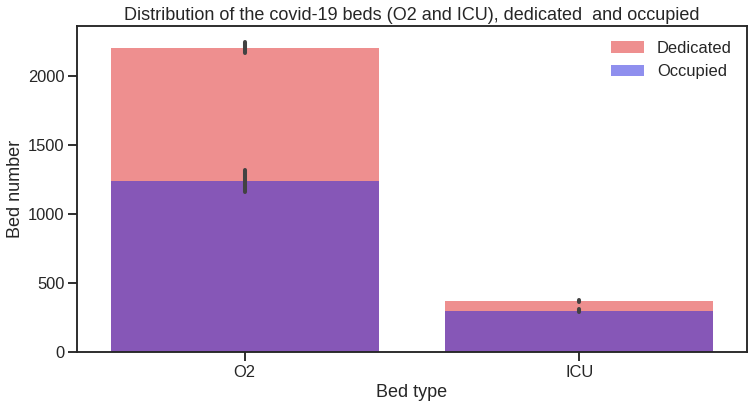

In [33]:

sns.set_style(style=None, rc=None )
ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12,6))

#sns.scaterplot(data = df_Reg['lits_o2_occ'], marker='o', ax=ax1, label='Lits O2 occupés')
#ax2 = ax1.twinx()

sns.barplot(data = df_Nat, order=['lits_o2','lits_rea'],alpha=0.5, ax=ax1,label='Dedicated',color=c[0])
sns.barplot(data = df_Nat, order=['lits_o2_occ','lits_rea_occ'],alpha=0.5, ax=ax1,label='Occupied',color=c[1])

ax1.set_title('Distribution of the covid-19 beds (O2 and ICU), dedicated  and occupied');
ax1.set_xticklabels(['O2', 'ICU'])
ax1.set_xlabel('Bed type')
ax1.set_ylabel('Bed number')
plt.legend()
#plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90) 

plt.savefig("bedsDistribution"+str(todayDate.date())+".png")
plt.show() 

In [34]:
a

,lits_rea,lits_rea_occ,lits_rea_disp,lits_o2,lits_o2_occ,lits_o2_disp,z_tamp
2021-01-01,285.0,225.0,60.0,1938.0,872.0,1066.0,97.0
2021-01-02,288.0,235.0,53.0,1935.0,878.0,1057.0,105.0
2021-01-03,286.0,231.0,55.0,1934.0,889.0,1045.0,104.0
2021-01-04,289.0,233.0,56.0,1943.0,906.0,1037.0,84.0
2021-01-05,290.0,237.0,53.0,1952.0,909.0,1043.0,94.0
...,...,...,...,...,...,...,...
2021-07-13,534.0,499.0,35.0,3171.0,2758.0,413.0,398.0
2021-07-14,535.0,496.0,39.0,3195.0,2822.0,373.0,384.0
2021-07-15,533.0,507.0,26.0,3319.0,2921.0,398.0,392.0
2021-07-16,538.0,509.0,29.0,3348.0,2956.0,392.0,396.0


# Correlation analysis

In [35]:
df_4=df_Nat.drop("z_tamp", axis=1)

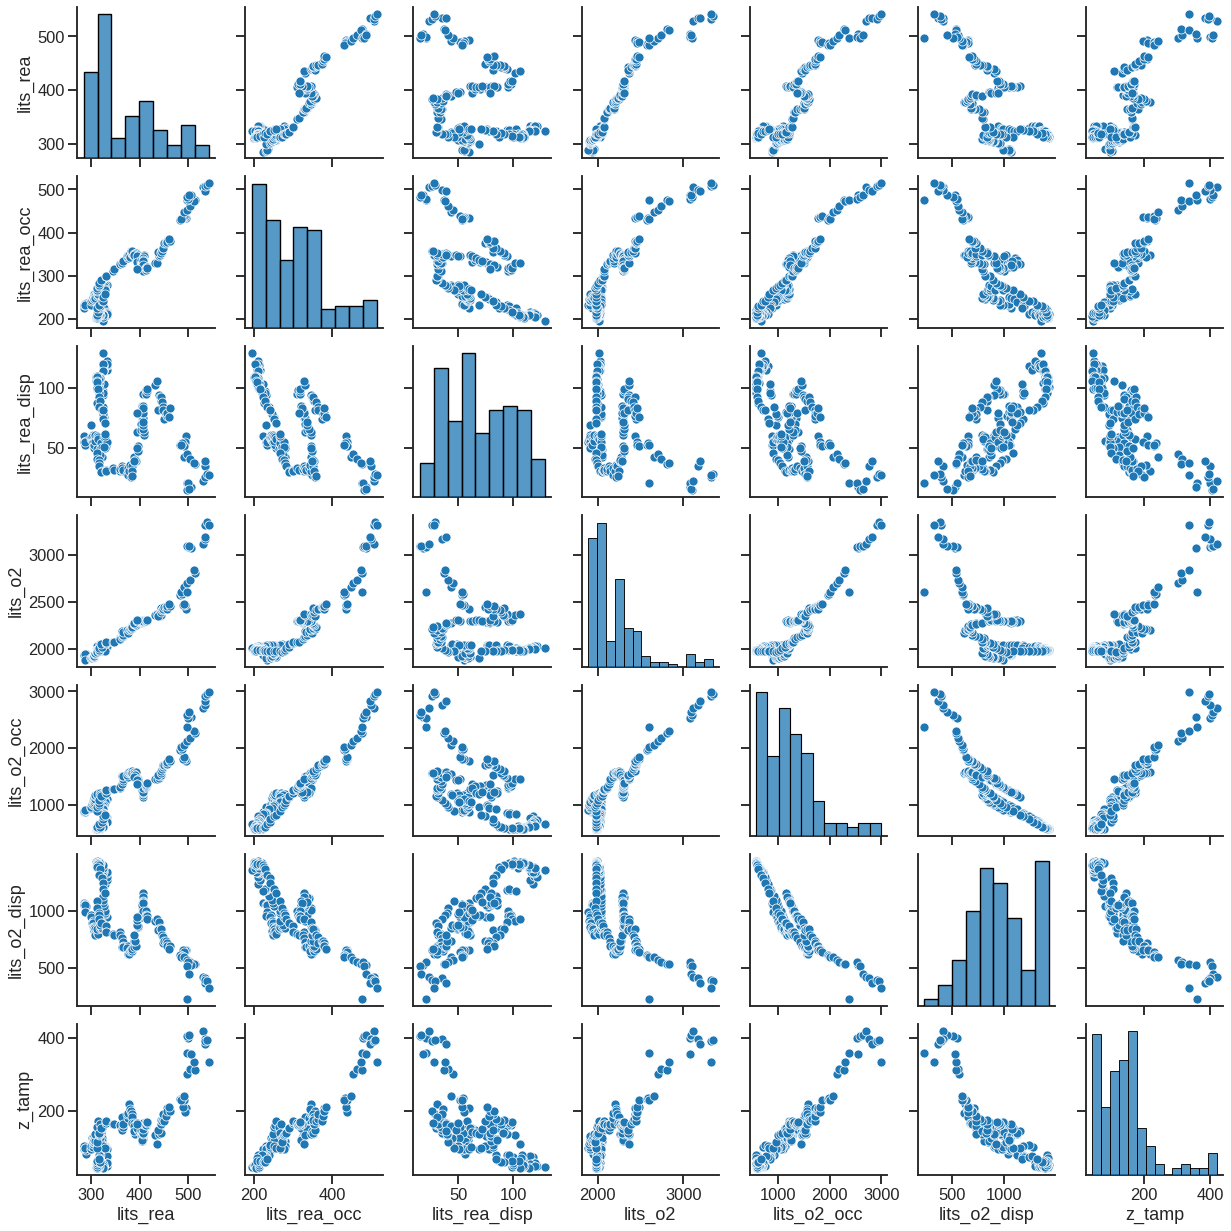

In [36]:
w=pd.date_range(start=ddf.date.min(), end=ddf.date.max(), freq='D')
a=df_Nat.loc[w]

#fig, ax = plt.subplots(figsize=(12,6))

p=sns.pairplot(a, kind="scatter")

            

plt.savefig('pairplot'+str(todayDate.date())+".png")
plt.show()

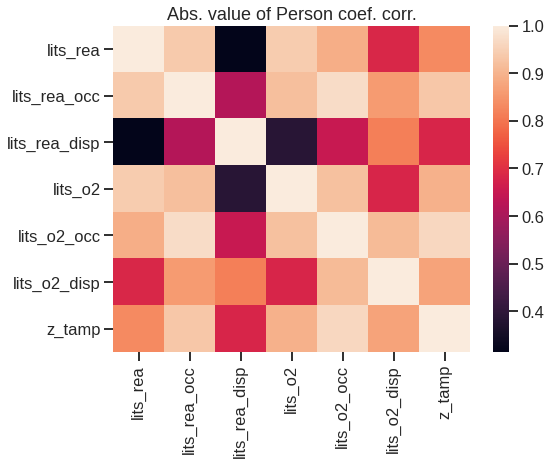

In [37]:
fig, ax = plt.subplots(figsize=(8,6))
cormat = a.corr()
round(cormat,2)
p=sns.heatmap(np.abs(cormat),ax=ax)
p.set_title('Abs. value of Person coef. corr.')

plt.savefig('CorrCoef_'+str(todayDate.date())+".png")

In [38]:
linear_regressor = LinearRegression(fit_intercept=True)  # create object for the class
a.columns
for i in np.arange(len(a.columns)-1):
    for j in np.arange(i+1,len(a.columns)-1):
        X = a[a.columns[i]].values.reshape(-1, 1)[2:]  # values converts it into a numpy array
        Y = a[a.columns[j]].values.reshape(-1, 1)[2:]  #
        linear_regressor.fit(X,Y )  # perform linear regression
        Y_pred = linear_regressor.predict(X)  # make predictions
        print('coef cor.('+a.columns[i]+', '+a.columns[j]+')=',linear_regressor.coef_[0])
        r=np.corrcoef(x=np.transpose(X),y=np.transpose(Y))
        if np.abs(r[0,1])>0.5: print('coef cor pearson=',r[0,1], '\n')
        else: print('\n')

coef cor.(lits_rea, lits_rea_occ)= [1.1407187]
coef cor pearson= 0.9404138593904852 

coef cor.(lits_rea, lits_rea_disp)= [-0.1407187]


coef cor.(lits_rea, lits_o2)= [4.25609565]
coef cor pearson= 0.9434938044178107 

coef cor.(lits_rea, lits_o2_occ)= [7.1815065]
coef cor pearson= 0.8926626226630932 

coef cor.(lits_rea, lits_o2_disp)= [-2.9252452]
coef cor pearson= -0.687315333081186 

coef cor.(lits_rea_occ, lits_rea_disp)= [-0.22471839]
coef cor pearson= -0.6254740695466913 

coef cor.(lits_rea_occ, lits_o2)= [3.41920417]
coef cor pearson= 0.9194163986683116 

coef cor.(lits_rea_occ, lits_o2_occ)= [6.44195437]
coef cor pearson= 0.9712901295019187 

coef cor.(lits_rea_occ, lits_o2_disp)= [-3.02256009]
coef cor pearson= -0.8614463564242665 

coef cor.(lits_rea_disp, lits_o2)= [-4.07947376]


coef cor.(lits_rea_disp, lits_o2_occ)= [-12.0940049]
coef cor pearson= -0.6551349618810468 

coef cor.(lits_rea_disp, lits_o2_disp)= [8.01393047]
coef cor pearson= 0.8205936848856035 

coef cor.(

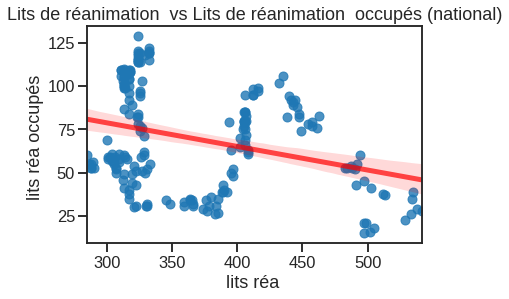

In [39]:
# Regression
sns.set_style(style=None, rc=None )
s=sns.regplot(x='lits_rea',y='lits_rea_disp',data=df_Nat,line_kws={"color":"r","alpha":0.7,"lw":5})
plt.xlabel(' lits réa  ')
plt.ylabel('lits réa occupés ')
plt.title('Lits de réanimation  vs Lits de réanimation  occupés (national)')

s.figure.savefig("reded_vs_reo_cc"+str(todayDate.date())+".png") 

### Time analysis

In [40]:
n=7
Date=pd.to_datetime('2021-5-14')
    #plt.vlines(Date,ymin=-10,ymax=5000,lw=0.8 )    
Date1=pd.to_datetime('2021-6-5')
w_occ2 = pd.date_range(start=Date, end=Date1, freq='D')

date=a.lits_rea_occ.rolling(n).mean().loc[w_occ2].idxmin()



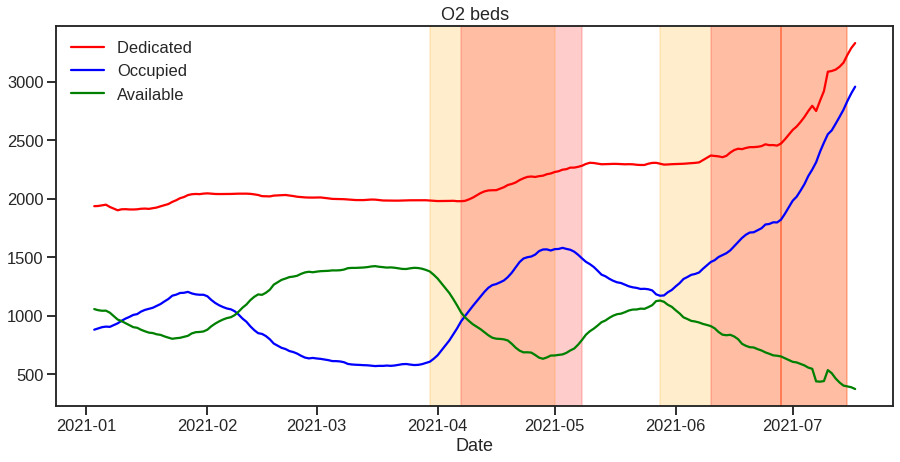

In [41]:

fig, ax = plt.subplots(figsize=(15,7))
n=3
ax.plot(a.index,a.lits_o2.rolling(n).mean(), color=c[0], label="Dedicated ")
ax.plot(a.index,a.lits_o2_occ.rolling(n).mean(), color=c[1], label="Occupied")
ax.plot(a.index,a.lits_o2_disp.rolling(n).mean(), color=c[2], label="Available")

##############################################

############################
Date=pd.to_datetime('2021-3-30')
    #plt.vlines(Date,ymin=-10,ymax=5000,lw=0.8 )    
Date1=pd.to_datetime('2021-5-1')
w_occ1 = pd.date_range(start=Date, end=Date1, freq='D')
ax.axvspan(Date,Date1, color='orange', alpha=0.2)  
sns.set_context("talk")


Date=pd.to_datetime('2021-5-28')
    #plt.vlines(Date,ymin=-10,ymax=5000,lw=0.8 )    
Date1=pd.to_datetime('2021-6-28')
w_occ2 = pd.date_range(start=Date, end=Date1, freq='D')
ax.axvspan(Date,Date1, color='orange', alpha=0.2)  
sns.set_context("talk")


Date=pd.to_datetime('2021-6-28')
    #plt.vlines(Date,ymin=-10,ymax=5000,lw=0.8 )    
Date1=pd.to_datetime('2021-7-15')
w_occ3 = pd.date_range(start=Date, end=Date1, freq='D')
ax.axvspan(Date,Date1, color='orange', alpha=0.2)  
sns.set_context("talk")


########################

Date=pd.to_datetime('2021-4-7')
    #plt.vlines(Date,ymin=-10,ymax=5000,lw=0.8 )    
Date1=pd.to_datetime('2021-5-8')
w_dedi1 = pd.date_range(start=Date, end=Date1, freq='D')
ax.axvspan(Date,Date1, color='red', alpha=0.2)  
sns.set_context("talk")


Date=pd.to_datetime('2021-6-10')
    #plt.vlines(Date,ymin=-10,ymax=5000,lw=0.8 )    
Date1=pd.to_datetime('2021-6-28')
w_dedi2 = pd.date_range(start=Date, end=Date1, freq='D')
ax.axvspan(Date,Date1, color='red', alpha=0.2)  
sns.set_context("talk")


Date=pd.to_datetime('2021-6-28')
    #plt.vlines(Date,ymin=-10,ymax=5000,lw=0.8 )    
Date1=pd.to_datetime('2021-7-15')
w_dedi3 = pd.date_range(start=Date, end=Date1, freq='D')
ax.axvspan(Date,Date1, color='red', alpha=0.2)  
sns.set_context("talk")

############################################

plt.title("O2 beds")
ax.set_xlabel("Date")
ax1.set_ylabel('Bed number')
plt.legend()
plt.show()
ax.figure.savefig("o2_national"+str(todayDate.date())+".png")

In [42]:
ww=w_dedi3
print((a.lits_o2.rolling(n).mean()[ww[-1]]-a.lits_o2.rolling(n).mean()[ww[0]])/len(ww))
ww=w_occ3
print((a.lits_o2_occ.rolling(n).mean()[ww[-1]]-a.lits_o2_occ.rolling(n).mean()[ww[0]])/len(ww))

42.05555555555556
56.29629629629629


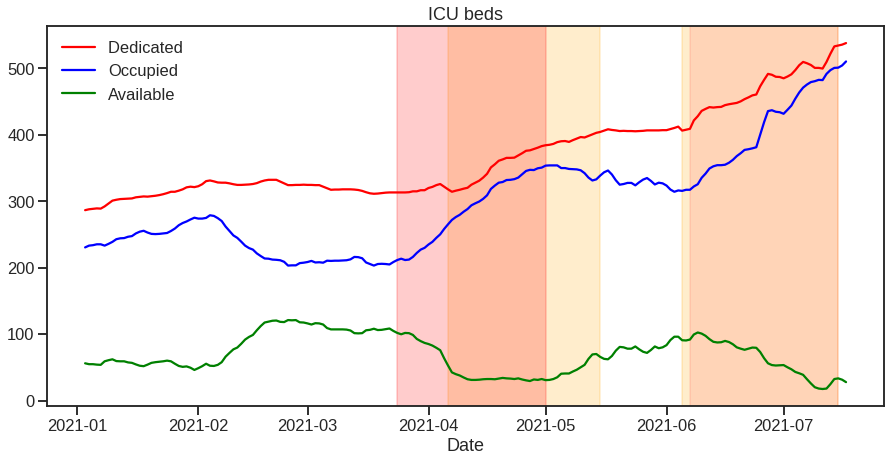

In [43]:

fig, ax = plt.subplots(figsize=(15,7))
n=3
plt.plot(a.index,a.lits_rea.rolling(n).mean(), color=c[0], label="Dedicated ")
plt.plot(a.index,a.lits_rea_occ.rolling(n).mean(), color=c[1], label="Occupied")
plt.plot(a.index,a.lits_rea_disp.rolling(n).mean(), color=c[2], label="Available")

############################
Date=pd.to_datetime('2021-4-6')
    #plt.vlines(Date,ymin=-10,ymax=5000,lw=0.8 )    
Date1=pd.to_datetime('2021-5-15')
w_occ1 = pd.date_range(start=Date, end=Date1, freq='D')
plt.axvspan(Date,Date1, color='orange', alpha=0.2)  
sns.set_context("talk")


Date=pd.to_datetime('2021-6-5')
    #plt.vlines(Date,ymin=-10,ymax=5000,lw=0.8 )    
Date1=pd.to_datetime('2021-7-15')
w_occ2 = pd.date_range(start=Date, end=Date1, freq='D')
plt.axvspan(Date,Date1, color='orange', alpha=0.2)  
sns.set_context("talk")




########################
Date=pd.to_datetime('2021-3-24')
    #plt.vlines(Date,ymin=-10,ymax=5000,lw=0.8 )    
Date1=pd.to_datetime('2021-5-1')
w_dedi1 = pd.date_range(start=Date, end=Date1, freq='D')
plt.axvspan(Date,Date1, color='red', alpha=0.2)  
sns.set_context("talk")


Date=pd.to_datetime('2021-6-7')
    #plt.vlines(Date,ymin=-10,ymax=5000,lw=0.8 )    
Date1=pd.to_datetime('2021-7-15')
w_dedi2 = pd.date_range(start=Date, end=Date1, freq='D')
plt.axvspan(Date,Date1, color='red', alpha=0.1)  
sns.set_context("talk")



############################################


plt.title("ICU beds")
ax.set_xlabel("Date")
ax1.set_ylabel('Bed number')
plt.legend()
plt.show()

ax.figure.savefig("ICU_national"+str(todayDate.date())+".png")

In [44]:
ww=w_dedi2
print((a.lits_rea.rolling(n).mean()[ww[-1]]-a.lits_rea.rolling(n).mean()[ww[0]])/len(ww))
ww=w_occ2
print((a.lits_rea_occ.rolling(n).mean()[ww[-1]]-a.lits_rea_occ.rolling(n).mean()[ww[0]])/len(ww))

3.2136752136752134
4.520325203252034


### Analyse lit occ rea vs lit o2

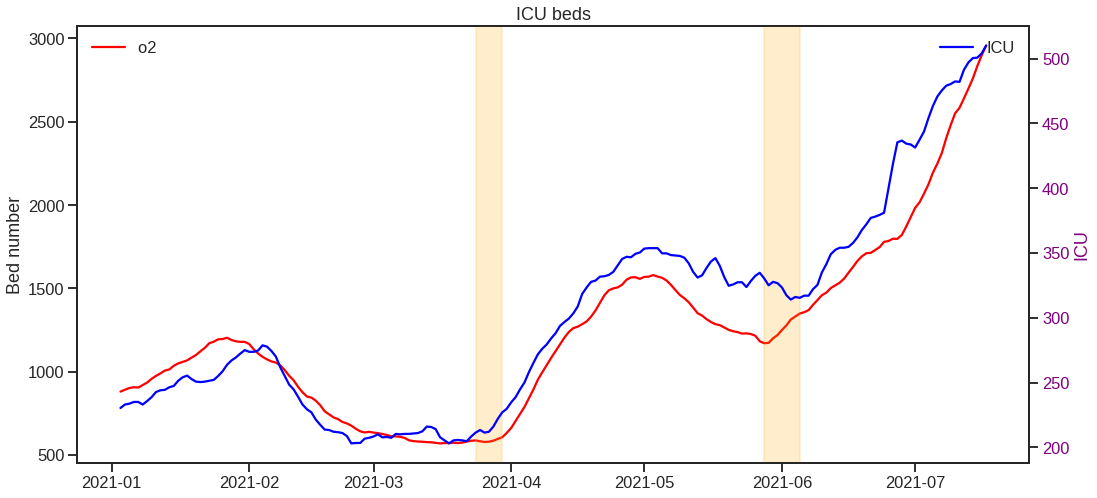

In [45]:

fig, ax1 = plt.subplots(figsize=(15,7))
n=3
ax1.plot(a.index,a.lits_o2_occ.rolling(n).mean(), color=c[0], label="o2 ")


ax1.legend(loc='upper left')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
delay=4

ax2.plot(a.index,a.lits_rea_occ.rolling(n).mean(), color=c[1], label="ICU")


fig.tight_layout()  # otherwise the right y-label is slightly clipped

#ax2.set_ylim(0,200)#125
#ax2.set_ylim(10,740)#125
ax2.legend(loc='upper right')
ax2.tick_params(axis='y', labelcolor="purple")
ax2.set_ylabel("ICU",color="purple")







############################
Date=pd.to_datetime('2021-3-24')
    #plt.vlines(Date,ymin=-10,ymax=5000,lw=0.8 )    
Date1=pd.to_datetime('2021-3-30')
w_occ1 = pd.date_range(start=Date, end=Date1, freq='D')
plt.axvspan(Date,Date1, color='orange', alpha=0.2)  
sns.set_context("talk")


Date=pd.to_datetime('2021-5-28')
    #plt.vlines(Date,ymin=-10,ymax=5000,lw=0.8 )    
Date1=pd.to_datetime('2021-6-5')
w_occ2 = pd.date_range(start=Date, end=Date1, freq='D')
plt.axvspan(Date,Date1, color='orange', alpha=0.2)  
sns.set_context("talk")





############################################


plt.title("ICU beds")
ax.set_xlabel("Date")
ax1.set_ylabel('Bed number')
plt.show()

ax.figure.savefig("ICUo2_national"+str(todayDate.date())+".png")

## Bed vs daily case and death analysis

In [46]:
ttn=pd.concat([tn,df_Nat],axis=1)
ttn.head()

w=pd.date_range(start=ddf.date.min(), end=ddf.date.max(), freq='D')
a=ttn.loc[w]

In [47]:
a

,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,fittedNewCasesSMA,fittedNewDeathSMA,fittedDeathSMA,lits_rea,lits_rea_occ,lits_rea_disp,lits_o2,lits_o2_occ,lits_o2_disp,z_tamp
2021-01-01,1924.0,139140.0,56.0,4676.0,1782.408061,51.109778,4670.145833,285.0,225.0,60.0,1938.0,872.0,1066.0,97.0
2021-01-02,1417.0,140557.0,54.0,4730.0,1826.950011,52.025643,4720.541667,288.0,235.0,53.0,1935.0,878.0,1057.0,105.0
2021-01-03,1422.0,141979.0,35.0,4765.0,1881.690394,52.976760,4771.750000,286.0,231.0,55.0,1934.0,889.0,1045.0,104.0
2021-01-04,1565.0,143544.0,35.0,4800.0,1947.258687,53.961555,4824.187500,289.0,233.0,56.0,1943.0,906.0,1037.0,84.0
2021-01-05,1252.0,144796.0,62.0,4862.0,2023.161711,54.978354,4878.340278,290.0,237.0,53.0,1952.0,909.0,1043.0,94.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-13,4310.0,501923.0,106.0,16494.0,7202.615917,146.517975,16528.277778,534.0,499.0,35.0,3171.0,2758.0,413.0,398.0
2021-07-14,8473.0,510396.0,157.0,16651.0,7103.090284,148.961639,16691.173611,535.0,496.0,39.0,3195.0,2822.0,373.0,384.0
2021-07-15,8213.0,518609.0,194.0,16845.0,6969.096331,151.141911,16856.055556,533.0,507.0,26.0,3319.0,2921.0,398.0,392.0
2021-07-16,7878.0,526487.0,164.0,17009.0,6812.591285,153.044214,17020.340278,538.0,509.0,29.0,3348.0,2956.0,392.0,396.0


### Daily case-bed analysis

No handles with labels found to put in legend.


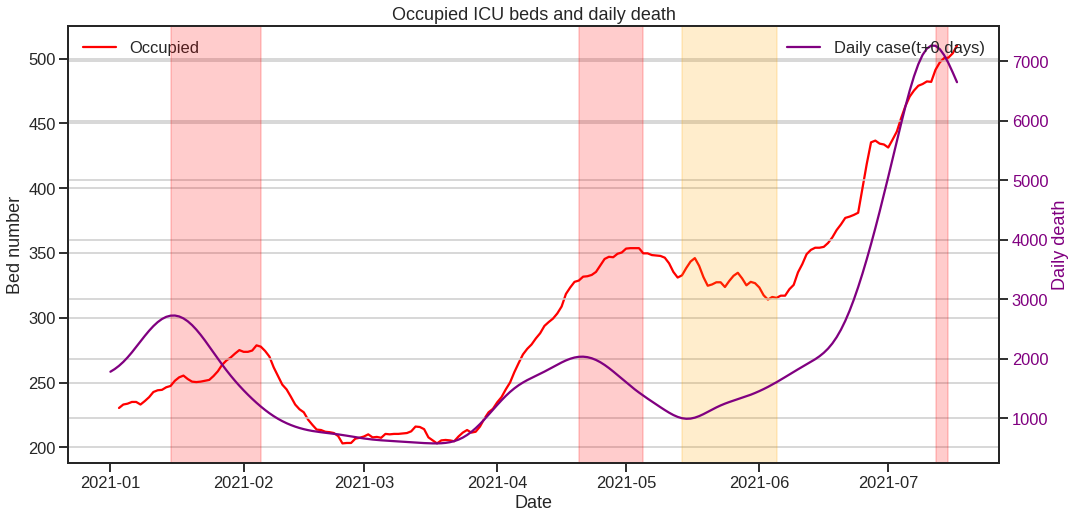

In [48]:

fig, ax1 = plt.subplots(figsize=(15,7))
n=3

ax1.legend(loc='upper left')
ax1.set_ylabel('daily cases')

#ax1.plot(a.index,a.lits_rea.rolling(n).mean(), color=c[1], label=label[0])
ax1.plot(a.index,a.lits_rea_occ.rolling(n).mean(), color=c[0], label=label[1])
#ax1.plot(a.index,a.lits_rea_disp.rolling(n).mean(), color=c[2], label=label[2])

ax1.legend(loc='upper left')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
delay=0

ax2.plot(a.index,a.fittedNewCasesSMA.shift(periods=delay), color="purple", label="Daily case(t+"+str(delay)+" days)")

fig.tight_layout()  # otherwise the right y-label is slightly clipped

#ax2.set_ylim(0,200)#125
#ax2.set_ylim(10,5000)#125
ax2.legend(loc='upper right')
ax2.tick_params(axis='y', labelcolor="purple")
ax2.set_ylabel("Daily death",color="purple")




############################

Date=pd.to_datetime('2021-5-14')
    #plt.vlines(Date,ymin=-10,ymax=5000,lw=0.8 )    
Date1=pd.to_datetime('2021-6-5')
w_occ1 = pd.date_range(start=Date, end=Date1, freq='D')
plt.axvspan(Date,Date1, color='orange', alpha=0.2)  
sns.set_context("talk")

Date=pd.to_datetime('2021-4-20')
    #plt.vlines(Date,ymin=-10,ymax=5000,lw=0.8 )    
Date1=pd.to_datetime('2021-5-5')
w_occ2 = pd.date_range(start=Date, end=Date1, freq='D')
plt.axvspan(Date,Date1, color='red', alpha=0.2)  
sns.set_context("talk")
# 15 j

Date=pd.to_datetime('2021-7-12')
    #plt.vlines(Date,ymin=-10,ymax=5000,lw=0.8 )    
Date1=pd.to_datetime('2021-7-15')
w_occ3 = pd.date_range(start=Date, end=Date1, freq='D')
plt.axvspan(Date,Date1, color='red', alpha=0.2)  
sns.set_context("talk")
# 20 j


Date=pd.to_datetime('2021-1-15')
    #plt.vlines(Date,ymin=-10,ymax=5000,lw=0.8 )    
Date1=pd.to_datetime('2021-2-5')
w_occ4 = pd.date_range(start=Date, end=Date1, freq='D')
plt.axvspan(Date,Date1, color='red', alpha=0.2)  
sns.set_context("talk")
# 20 j

##########################################

plt.title("Occupied ICU beds and daily death")
ax1.set_xlabel("Date")
ax1.set_ylabel("Bed number")
ax1.grid(axis='y')


plt.grid(axis ='y')
plt.show()


ax2.figure.savefig('CasesICU_national'+str(todayDate.date())+'.png')

### Death-bed analysis

No handles with labels found to put in legend.


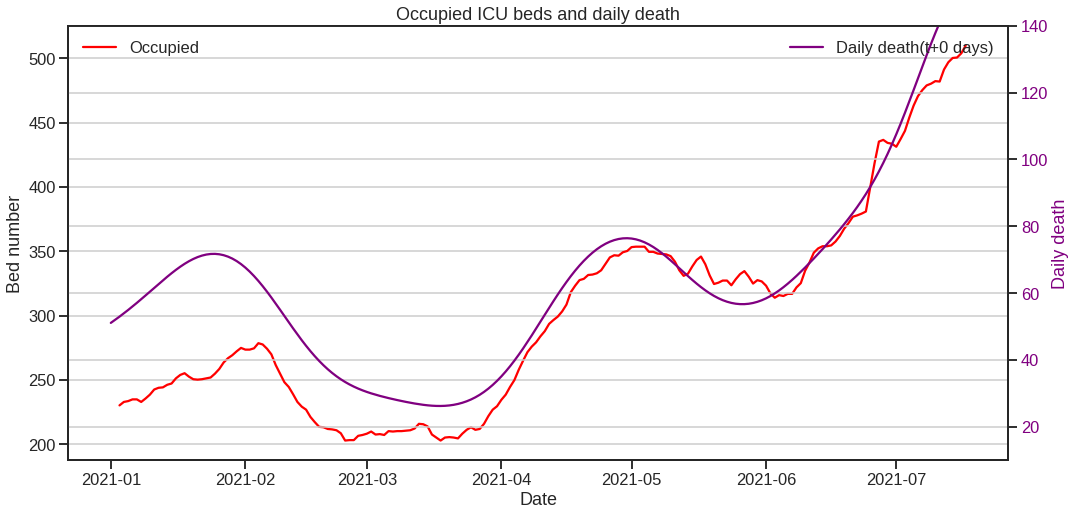

In [49]:
fig, ax1 = plt.subplots(figsize=(15,7))
n=3

ax1.legend(loc='upper left')
ax1.set_ylabel('daily cases')

#ax1.plot(a.index,a.lits_rea.rolling(n).mean(), color=c[1], label=label[0])
ax1.plot(a.index,a.lits_rea_occ.rolling(n).mean(), color=c[0], label=label[1])
#ax1.plot(a.index,a.lits_rea_disp.rolling(n).mean(), color=c[2], label=label[2])

ax1.legend(loc='upper left')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
delay=0

ax2.plot(a.index,a.fittedNewDeathSMA.shift(periods=delay), color="purple", label="Daily death(t+"+str(delay)+" days)")

fig.tight_layout()  # otherwise the right y-label is slightly clipped

#ax2.set_ylim(0,200)#125
ax2.set_ylim(10,140)#125
ax2.legend(loc='upper right')
ax2.tick_params(axis='y', labelcolor="purple")
ax2.set_ylabel("Daily death",color="purple")




plt.title("Occupied ICU beds and daily death")
ax1.set_xlabel("Date")
ax1.set_ylabel("Bed number")
ax1.grid(axis='y')


plt.grid(axis ='y')



ax2.figure.savefig('DeathICU'+str(todayDate.date())+'.png')
plt.show()

In [50]:
# calcul du coef de correlation entre les DC et ICU
X = a.lits_rea_occ.rolling(n).mean().values.reshape(-1, 1)[2:]  # values converts it into a numpy array
Y = a.fittedNewDeathSMA.shift(periods=delay).values.reshape(-1, 1)[2:]  #
r=np.corrcoef(x=np.transpose(X),y=np.transpose(Y))
print('coef. cor. pearson=',r[0,1], '\n')


coef. cor. pearson= 0.9248483465447768 



In [51]:
w_occ2

DatetimeIndex(['2021-04-20', '2021-04-21', '2021-04-22', '2021-04-23',
               '2021-04-24', '2021-04-25', '2021-04-26', '2021-04-27',
               '2021-04-28', '2021-04-29', '2021-04-30', '2021-05-01',
               '2021-05-02', '2021-05-03', '2021-05-04', '2021-05-05'],
              dtype='datetime64[ns]', freq='D')

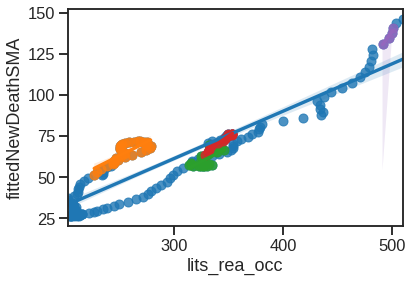

In [52]:
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)

Date=pd.to_datetime('2021-1-12')
    #plt.vlines(Date,ymin=-10,ymax=5000,lw=0.8 )    
Date1=pd.to_datetime('2021-2-15')
w = pd.date_range(start=Date, end=Date1, freq='D')

delay=4
g = sns.regplot(
    x=a.lits_rea_occ.rolling(n).mean(), y=a.fittedNewDeathSMA.shift(periods=delay)
)

g = sns.regplot(
    x=a.lits_rea_occ.rolling(n).mean().loc[w], y=a.fittedNewDeathSMA.shift(periods=delay).loc[w]
)

g = sns.regplot(
    x=a.lits_rea_occ.rolling(n).mean().loc[w_occ1], y=a.fittedNewDeathSMA.shift(periods=delay).loc[w_occ1]
)
g = sns.regplot(
    x=a.lits_rea_occ.rolling(n).mean().loc[w_occ2], y=a.fittedNewDeathSMA.shift(periods=delay).loc[w_occ2])

g = sns.regplot(
    x=a.lits_rea_occ.rolling(n).mean().loc[w_occ3], y=a.fittedNewDeathSMA.shift(periods=delay).loc[w_occ3]
)


## Evaluating daily death from bed occupency: 
Ratio analysis: daily death and occupied ICU 

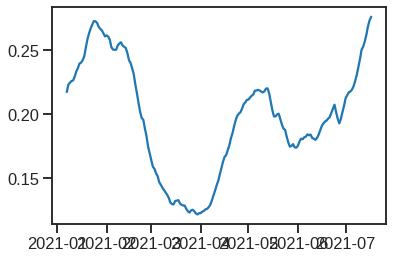

In [53]:
delay=6
a['ratio_bedDeath']=a.fittedNewDeathSMA.shift(periods=delay)/a.lits_rea_occ.rolling(n).mean()
plt.plot(a.ratio_bedDeath)

No handles with labels found to put in legend.


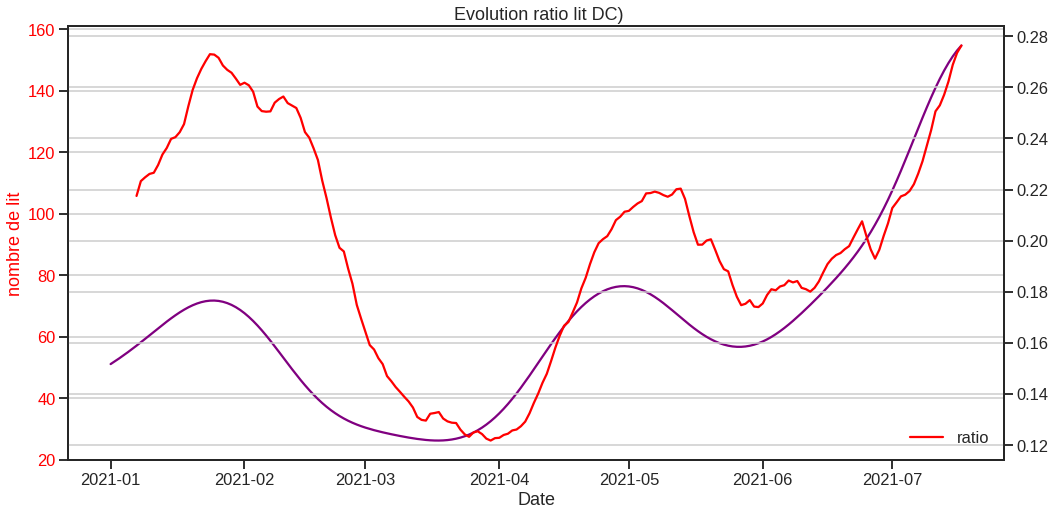

In [54]:
fig, ax1 = plt.subplots(figsize=(15,7))
n=3
ax1.tick_params(axis='y', labelcolor='red')

ax1.legend(loc='upper left')
ax1.set_ylabel('daily cases', color='red')


#ax1.plot(a.index,a.lits_rea.rolling(n).mean(), color="midnightblue", label="Lits o2 dedille ")
#ax1.plot(a.index,a.lits_rea_occ.rolling(n).mean(), color="darkred", label="Lits o2 occupé")
ax1.plot(a.index,a.fittedNewDeathSMA, color="purple", label="DC")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'

ax2.plot(a.ratio_bedDeath.index,a.ratio_bedDeath, color="red", label="ratio")

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.title(" Evolution ratio lit DC)")
ax1.set_xlabel("Date")
ax1.set_ylabel("nombre de lit")
ax1.grid(axis='y')
#ax1.set_ylim(0,200)#125

ax2.legend(loc='lower right')




sns.set_context("talk")



plt.grid(axis ='y')
plt.show()


In [55]:
#date1='2021-03-26'
#date2='2021-04-05'
#w=pd.date_range(start=date1, end=date2, freq='D')


ratioMin=a.ratio_bedDeath.min()

a['deathMin']=np.min([ratioMin*a.lits_rea_occ.rolling(n).mean(),a.fittedNewDeathSMA],axis=0)

ratioMax=a.ratio_bedDeath.max()
a['deathMax']=np.min([ratioMax*a.lits_rea_occ.rolling(n).mean(),a.fittedNewDeathSMA],axis=0)


ratioMean=a.ratio_bedDeath.mean()
a['deathMean']=np.min([ratioMean*a.lits_rea_occ.rolling(n).mean(),a.fittedNewDeathSMA],axis=0)



In [56]:
a

,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,fittedNewCasesSMA,fittedNewDeathSMA,fittedDeathSMA,lits_rea,lits_rea_occ,lits_rea_disp,lits_o2,lits_o2_occ,lits_o2_disp,z_tamp,ratio_bedDeath,deathMin,deathMax,deathMean
2021-01-01,1924.0,139140.0,56.0,4676.0,1782.408061,51.109778,4670.145833,285.0,225.0,60.0,1938.0,872.0,1066.0,97.0,NaN,NaN,NaN,NaN
2021-01-02,1417.0,140557.0,54.0,4730.0,1826.950011,52.025643,4720.541667,288.0,235.0,53.0,1935.0,878.0,1057.0,105.0,NaN,NaN,NaN,NaN
2021-01-03,1422.0,141979.0,35.0,4765.0,1881.690394,52.976760,4771.750000,286.0,231.0,55.0,1934.0,889.0,1045.0,104.0,NaN,28.059608,52.976760,45.431934
2021-01-04,1565.0,143544.0,35.0,4800.0,1947.258687,53.961555,4824.187500,289.0,233.0,56.0,1943.0,906.0,1037.0,84.0,NaN,28.384466,53.961555,45.957919
2021-01-05,1252.0,144796.0,62.0,4862.0,2023.161711,54.978354,4878.340278,290.0,237.0,53.0,1952.0,909.0,1043.0,94.0,NaN,28.465680,54.978354,46.089415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-13,4310.0,501923.0,106.0,16494.0,7202.615917,146.517975,16528.277778,534.0,499.0,35.0,3171.0,2758.0,413.0,398.0,0.257054,60.545405,137.330744,98.030411
2021-07-14,8473.0,510396.0,157.0,16651.0,7103.090284,148.961639,16691.173611,535.0,496.0,39.0,3195.0,2822.0,373.0,384.0,0.262233,60.951478,138.251809,98.687892
2021-07-15,8213.0,518609.0,194.0,16845.0,6969.096331,151.141911,16856.055556,533.0,507.0,26.0,3319.0,2921.0,398.0,392.0,0.268790,60.992085,138.343916,98.753640
2021-07-16,7878.0,526487.0,164.0,17009.0,6812.591285,153.044214,17020.340278,538.0,509.0,29.0,3348.0,2956.0,392.0,396.0,0.273465,61.398157,139.264980,99.411121


No handles with labels found to put in legend.


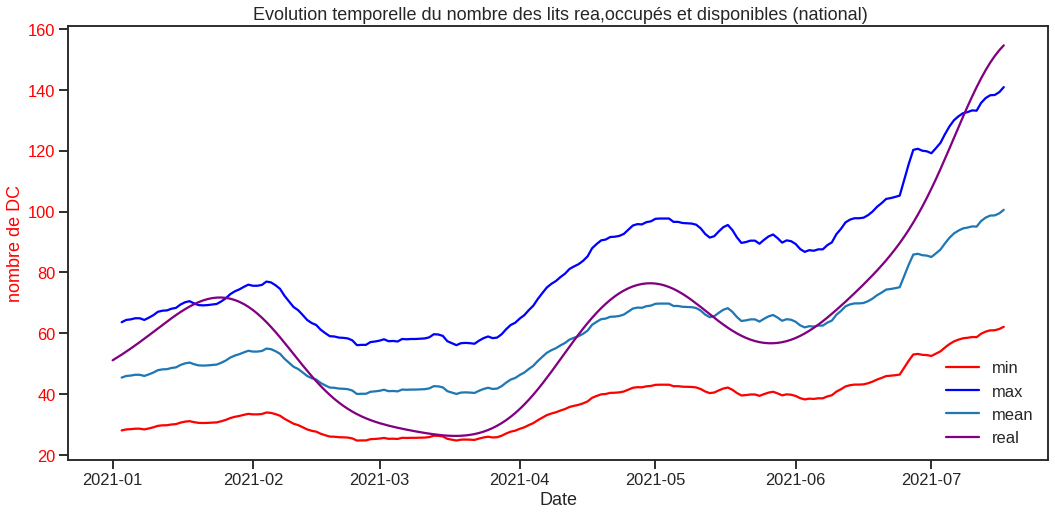

In [57]:
fig, ax1 = plt.subplots(figsize=(15,7))
n=3
ax1.tick_params(axis='y', labelcolor='red')

ax1.legend(loc='upper left')
ax1.set_ylabel('daily cases', color='red')


ax1.plot(a.index,ratioMin*a.lits_rea_occ.rolling(n).mean(), color="red", label="min")
ax1.plot(a.index,ratioMax*a.lits_rea_occ.rolling(n).mean(), color="blue", label="max")
ax1.plot(a.index,ratioMean*a.lits_rea_occ.rolling(n).mean(), label="mean")
ax1.plot(a.index,a.fittedNewDeathSMA, color="purple", label="real")

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.title(" Evolution temporelle du nombre des lits rea,occupés et disponibles (national)")
ax1.set_xlabel("Date")
ax1.set_ylabel("nombre de DC")
ax1.grid(axis='y')
#ax2.set_ylim(0,200)#125

ax1.legend(loc='lower right')




sns.set_context("talk")



plt.grid(axis ='y')
plt.show()


No handles with labels found to put in legend.


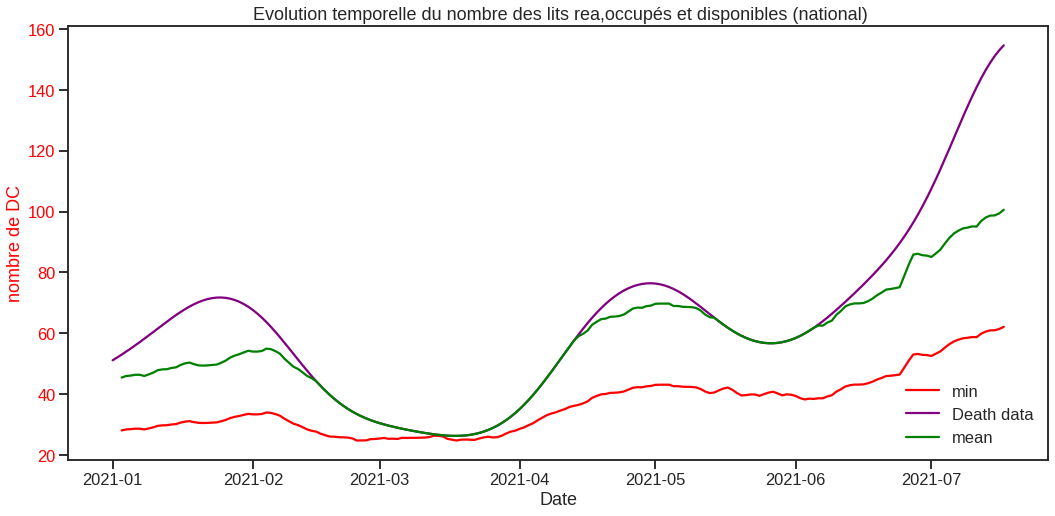

In [58]:
fig, ax1 = plt.subplots(figsize=(15,7))
n=3
ax1.tick_params(axis='y', labelcolor='red')

ax1.legend(loc='upper left')
ax1.set_ylabel('daily cases', color='red')


ax1.plot(a.index,ratioMin*a.lits_rea_occ.rolling(n).mean(), color="red", label="min")
#ax1.plot(a.index,ratioMax*a.lits_rea_occ.rolling(n).mean(), color="blue", label="max")
#ax1.plot(a.index,ratioMean*a.lits_rea_occ.rolling(n).mean(), label="mean")
ax1.plot(a.index,a.fittedNewDeathSMA, color="purple", label="Death data")
ax1.plot(a.index,a.deathMean, color="green", label="mean")



fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.title(" Evolution temporelle du nombre des lits rea,occupés et disponibles (national)")
ax1.set_xlabel("Date")
ax1.set_ylabel("nombre de DC")
ax1.grid(axis='y')
ax2.set_ylim(0,200)#125

ax1.legend(loc='lower right')




sns.set_context("talk")



plt.grid(axis ='y')
plt.show()


In [59]:
missingDeath_ICUBed=np.trapz((a.fittedNewDeathSMA-a.deathMean).dropna())
missingDeath_ICUBed

1522.7264934310333

No handles with labels found to put in legend.


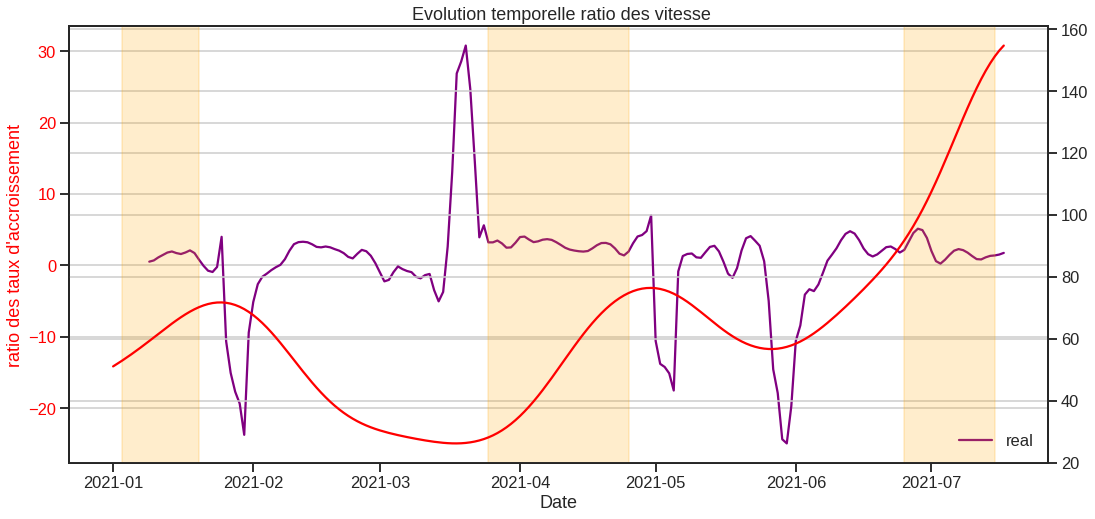

In [60]:
fig, ax1 = plt.subplots(figsize=(15,7))
n=3
ax1.tick_params(axis='y', labelcolor='red')

ax1.legend(loc='upper left')
ax1.set_ylabel('daily cases', color='red')

b=a.lits_rea_occ.rolling(n).mean().diff(2)/a.fittedNewDeathSMA.diff(2)
ax1.plot(a.index,b.rolling(5).mean(), color="purple", label="real")

fig.tight_layout()  # otherwise the right y-label is slightly clipped


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'


ax2.plot(a.index,a.fittedNewDeathSMA, color="red", label="daily death")

plt.title(" Evolution temporelle ratio des vitesse")
ax1.set_xlabel("Date")
ax1.set_ylabel("ratio des taux d'accroissement")
ax1.grid(axis='y')
#ax1.set_ylim(-10,10)#125

ax1.legend(loc='lower right')

Date=pd.to_datetime('2021-1-3')
    #plt.vlines(Date,ymin=-10,ymax=5000,lw=0.8 )    
Date1=pd.to_datetime('2021-1-20')
w1 = pd.date_range(start=Date, end=Date1, freq='D')
    #plt.vlines(Date,ymin=-10,ymax=5000,lw=0.8 )
plt.axvspan(Date,Date1, color='orange', alpha=0.2)  


Date=pd.to_datetime('2021-3-25')
    #plt.vlines(Date,ymin=-10,ymax=5000,lw=0.8 )    
Date1=pd.to_datetime('2021-4-25')
w2 = pd.date_range(start=Date, end=Date1, freq='D')
plt.axvspan(Date,Date1, color='orange', alpha=0.2)  
sns.set_context("talk")

Date=pd.to_datetime('2021-6-25')
    #plt.vlines(Date,ymin=-10,ymax=5000,lw=0.8 )    
Date1=pd.to_datetime('2021-7-15')
w3 = pd.date_range(start=Date, end=Date1, freq='D')
plt.axvspan(Date,Date1, color='orange', alpha=0.2)  
sns.set_context("talk")



plt.grid(axis ='y')
plt.show()

coef reg.= [0.64540955]


Text(0.5, 1.0, 'Lits de réanimation occ vs DC')

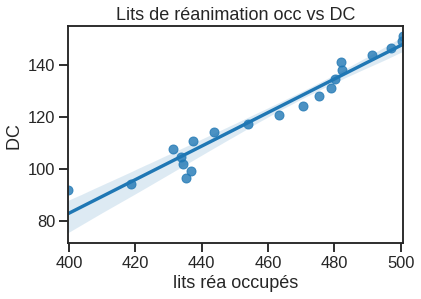

In [61]:
# Regression
linear_regressor = LinearRegression(fit_intercept=True)  # create object for the class
ww=w3
X = a.lits_rea_occ.rolling(n).mean().loc[ww].values.reshape(-1, 1)  # values converts it into a numpy array
Y = a.fittedNewDeathSMA.loc[ww].values.reshape(-1, 1)  #
linear_regressor.fit(X,Y )  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
print('coef reg.=',linear_regressor.coef_[0])

#sns.set_style(style=None, rc=None )
#sns.scater(x=a.lits_rea_occ.rolling(n).mean().loc[w1], y=a.fittedNewDeathSMA.loc[w1])
sns.regplot(x=a.lits_rea_occ.rolling(n).mean().loc[ww], y=a.fittedNewDeathSMA.loc[ww]) #regplot(x=a.lits_rea_occ.rolling(n).mean().loc[w1], y=Y_pred,line_kws={"color":"r","alpha":0.7,"lw":5})
plt.xlabel('lits réa occupés')
plt.ylabel('DC ')
plt.title('Lits de réanimation occ vs DC')



# Evaluation bed occupency from daily death (CoMo)

In [62]:
w=pd.date_range(start=ddf.date.min(), end=ddf.date.max(), freq='D')

In [77]:
ageDistDeath=np.array([1,2,3,10,16,68])
ageDistDeath=ageDistDeath/np.sum(ageDistDeath)


fatality=np.array([6.5,3.8,6.6,13,25.2,200])#p_hr
fatality=fatality/np.sum(fatality)

hospitalPrb=np.array([.025,.22,.28,.58,.6,.7])#p_ihr
hospitalPrb=hospitalPrb

pdeath_ho=0.2#Probability of dying when hospitalised if req O2:
pdeath_vent=0.8#Probability of dying when ventilated:
pdeath_icuo=.55#Probability of dying when admitted to ICU if req O2:


In [78]:


#pclin=.45#Probability upon infection of developing clinical symptoms


prob_icu=0.25#Probability upon hospitalisation of requiring ICU admission
prob_vent=0.48#Probability upon admission to the ICU of requiring a ventilator

# duration in hospital
nus=5 #Duration of hospitalised infection: (1 to 30)
nu_icu=7#Duration of ICU infection: (1 to 30)
nu_vent=7#Duration of ventilated infection: (1 to 30)
bedO2Duration=np.array([pd.Timedelta(nus, unit='d'),pd.Timedelta(nus, unit='d')]) # 1st column duration for dead, second for R
bedICUDuration=np.array([pd.Timedelta(nu_icu, unit='d'),pd.Timedelta(nu_icu, unit='d')]) # 1st column duration for dead, second for R
bedVentDuration=np.array([pd.Timedelta(nu_vent, unit='d'),pd.Timedelta(nu_vent, unit='d')]) # 1st column duration for dead, second for R


In [84]:
hospitaliseNonGrave=pd.DataFrame(index=a.index,columns=['<30','40','50','60','70','>70'])
hospitaliseO2=pd.DataFrame(index=a.index,columns=['<30','40','50','60','70','>70'])
hospitaliseICU=pd.DataFrame(index=a.index,columns=['<30','40','50','60','70','>70'])
hospitaliseVent=pd.DataFrame(index=a.index,columns=['<30','40','50','60','70','>70'])

for i in a.index:
    aa=a.fittedNewDeathSMA[i]*ageDistDeath*hospitalPrb/fatality#
    hospitaliseNonGrave.loc[i]=aa
    hospitaliseO2.loc[i]=(1-prob_icu)*pclin*aa
    hospitaliseICU.loc[i]=(1-prob_vent)*prob_icu*pclin*aa
    hospitaliseVent.loc[i]=prob_vent*prob_icu*pclin*aa

In [85]:
w1=pd.date_range(start='2021-01-01', end='2021-02-01', freq='D')
hospitaliseVent.loc[w1]

,<30,40,50,60,70,>70
2021-01-01,0.0270791,0.815225,0.896073,3.14118,2.68212,1.67566
2021-01-02,0.0275644,0.829833,0.912131,3.19747,2.73019,1.70568
2021-01-03,0.0280683,0.845004,0.928806,3.25592,2.7801,1.73687
2021-01-04,0.0285901,0.860712,0.946072,3.31645,2.83178,1.76915
2021-01-05,0.0291288,0.87693,0.963899,3.37894,2.88514,1.80249
2021-01-06,0.0296834,0.893626,0.98225,3.44327,2.94007,1.83681
2021-01-07,0.0302524,0.910757,1.00108,3.50928,2.99643,1.87202
2021-01-08,0.0308339,0.928263,1.02032,3.57673,3.05402,1.908
2021-01-09,0.0314253,0.946068,1.03989,3.64534,3.11261,1.9446
2021-01-10,0.0320235,0.964075,1.05969,3.71472,3.17185,1.98161


In [86]:
bedOcc=pd.DataFrame(index=tn.index,columns=['total','O2','ICU','Vent'])
bedOcc.fillna(0,inplace=True)

In [87]:
#hospitaliseD=pd.DataFrame(index=b.index,columns=['<30','40','50','60','70','>70'])

for i in a.index:
    p=1-pdeath_icuo
    w=pd.date_range(start=i-bedICUDuration[0], end=i, freq='D')
    bedOcc.loc[w,'ICU']=p*hospitaliseICU.loc[i].sum()*np.ones(len(w))+bedOcc.loc[w,'ICU']
    w=pd.date_range(start=i-bedICUDuration[1], end=i, freq='D')
    bedOcc.loc[w,'ICU']=(1-p)*hospitaliseICU.loc[i].sum()*np.ones(len(w))+bedOcc.loc[w,'ICU']
    
    p=1-pdeath_ho
    w=pd.date_range(start=i-bedO2Duration[0], end=i, freq='D')
    bedOcc.loc[w,'O2']=p*hospitaliseO2.loc[i].sum()*np.ones(len(w))+bedOcc.loc[w,'O2']
    w=pd.date_range(start=i-bedO2Duration[1], end=i, freq='D')
    bedOcc.loc[w,'O2']=(1-p)*hospitaliseO2.loc[i].sum()*np.ones(len(w))+bedOcc.loc[w,'O2']
    
    p=1-pdeath_vent
    w=pd.date_range(start=i-bedVentDuration[0], end=i, freq='D')
    bedOcc.loc[w,'Vent']=p*hospitaliseVent.loc[i].sum()*np.ones(len(w))+bedOcc.loc[w,'Vent']
    w=pd.date_range(start=i-bedVentDuration[1], end=i, freq='D')
    bedOcc.loc[w,'Vent']=(1-p)*hospitaliseVent.loc[i].sum()*np.ones(len(w))+bedOcc.loc[w,'Vent']

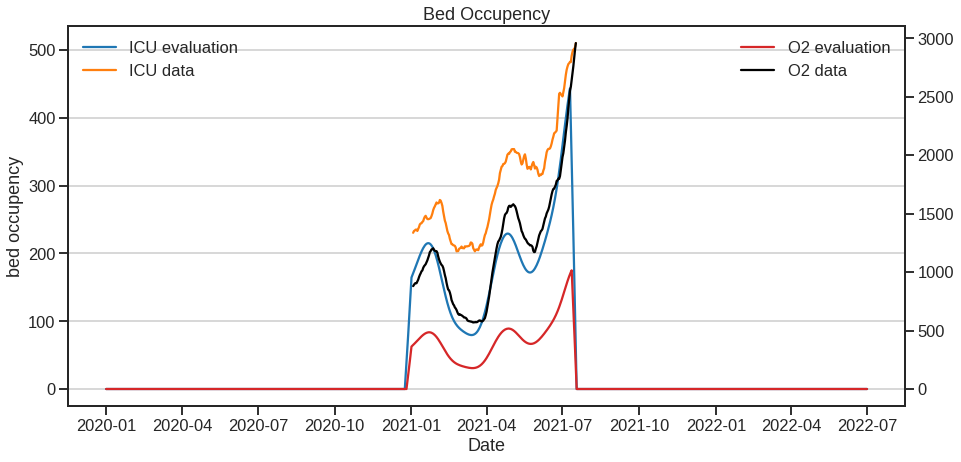

In [88]:
fig, ax1 = plt.subplots(figsize=(15,7))
ax.legend(loc='upper left')

ax1.plot(bedOcc.ICU+bedOcc.Vent, label='ICU evaluation')
ax1.plot(a.lits_rea_occ.rolling(n).mean(),label='ICU data')




###################################################
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'


ax2.plot(bedOcc.O2, color=color, label="O2 evaluation")
ax2.plot(a.lits_o2_occ.rolling(n).mean(),color='black',label='O2 data')

#########################


ax1.set_xlabel("Date")
ax1.set_ylabel("bed occupency")
ax1.grid(axis='y')
#ax1.set_ylim(0,10000)#125

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title("Bed Occupency")
plt.show()

# Regional analysis

In [70]:
w=pd.date_range(start=ddf.date.min(), end=ddf.date.max(), freq='D')
b=tn.loc[w]

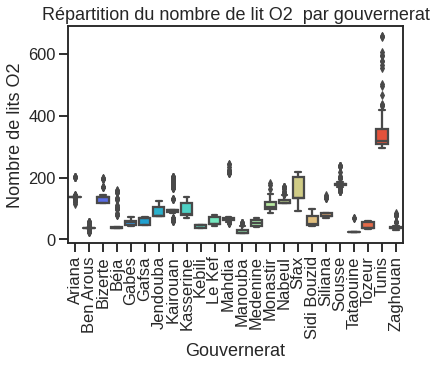

In [71]:
sns.set_style(style=None, rc=None )
g1=sns.boxplot(x='Gov',y='lits_o2',data=df_Reg,palette='rainbow');
g1.set_title(' Répartition du nombre de lit O2  par gouvernerat ');
g1.set_xlabel('Gouvernerat');
g1.set_ylabel('Nombre de lits O2');
plt.xticks(rotation=90);
g1.figure.savefig('o2_gov.png')

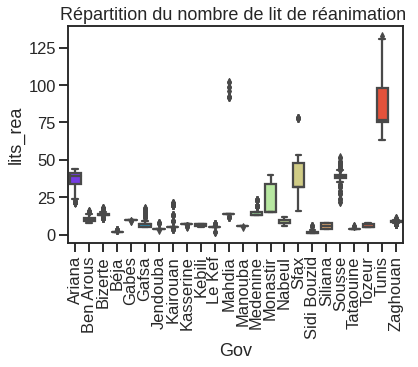

In [72]:
sns.set_style(style=None, rc=None )
g2=sns.boxplot(x='Gov',y='lits_rea',data=df_Reg,palette='rainbow');
g2.set_title('Répartition du nombre de lit de réanimation ');

plt.xticks(rotation=90);
g2.figure.savefig('rea_gov.png')

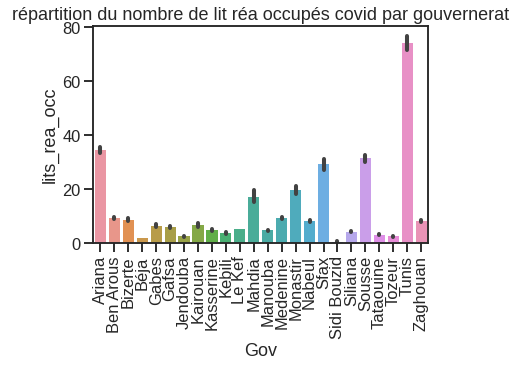

In [73]:
sns.set_style(style=None, rc=None )
p=sns.barplot(x='Gov',y='lits_rea_occ',data=df_Reg);
p.set_title(' répartition du nombre de lit réa occupés covid par gouvernerat ');

plt.xticks(rotation=90);
p.figure.savefig('rea_occ_gov.png')

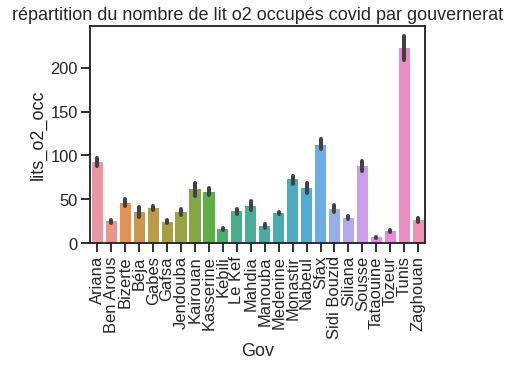

In [74]:
sns.set_style(style=None, rc=None )
p1=sns.barplot(x='Gov',y='lits_o2_occ',data=df_Reg);
p1.set_title(' répartition du nombre de lit o2 occupés covid par gouvernerat ');
plt.xticks(rotation=90);
p1.figure.savefig('o2_occ_gov.png')

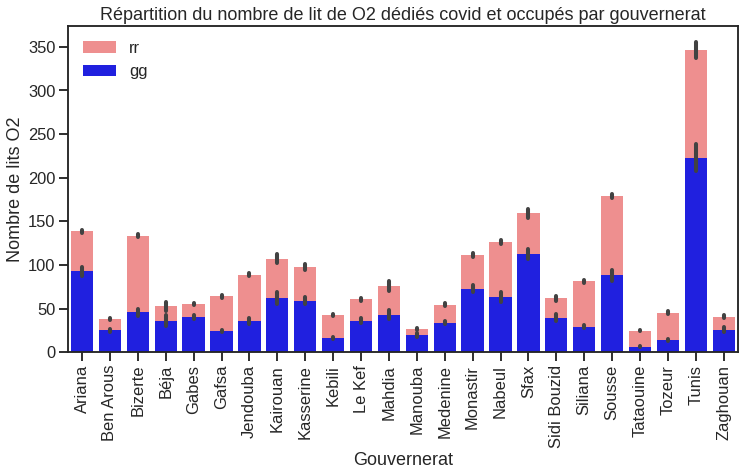

In [75]:
#sns.set_style("whitegrid") 

sns.set_style(style=None, rc=None )
ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12,6))

#sns.scaterplot(data = df_Reg['lits_o2_occ'], marker='o', ax=ax1, label='Lits O2 occupés')
#ax2 = ax1.twinx()

sns.barplot(data = df_Reg, x='Gov', y='lits_o2',alpha=0.5, ax=ax1,label='rr',color='r')
sns.barplot(data = df_Reg, x='Gov', y='lits_o2_occ',alpha=1, ax=ax1,label='gg',color='b')

ax1.set_title('Répartition du nombre de lit de O2 dédiés covid et occupés par gouvernerat');
ax1.set_xlabel('Gouvernerat')
ax1.set_ylabel('Nombre de lits O2');
plt.legend()
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90) 
plt.show() 
#plt.savefig('o2_occ_gov_nov.png')

KeyError: "['Date'] not in index"

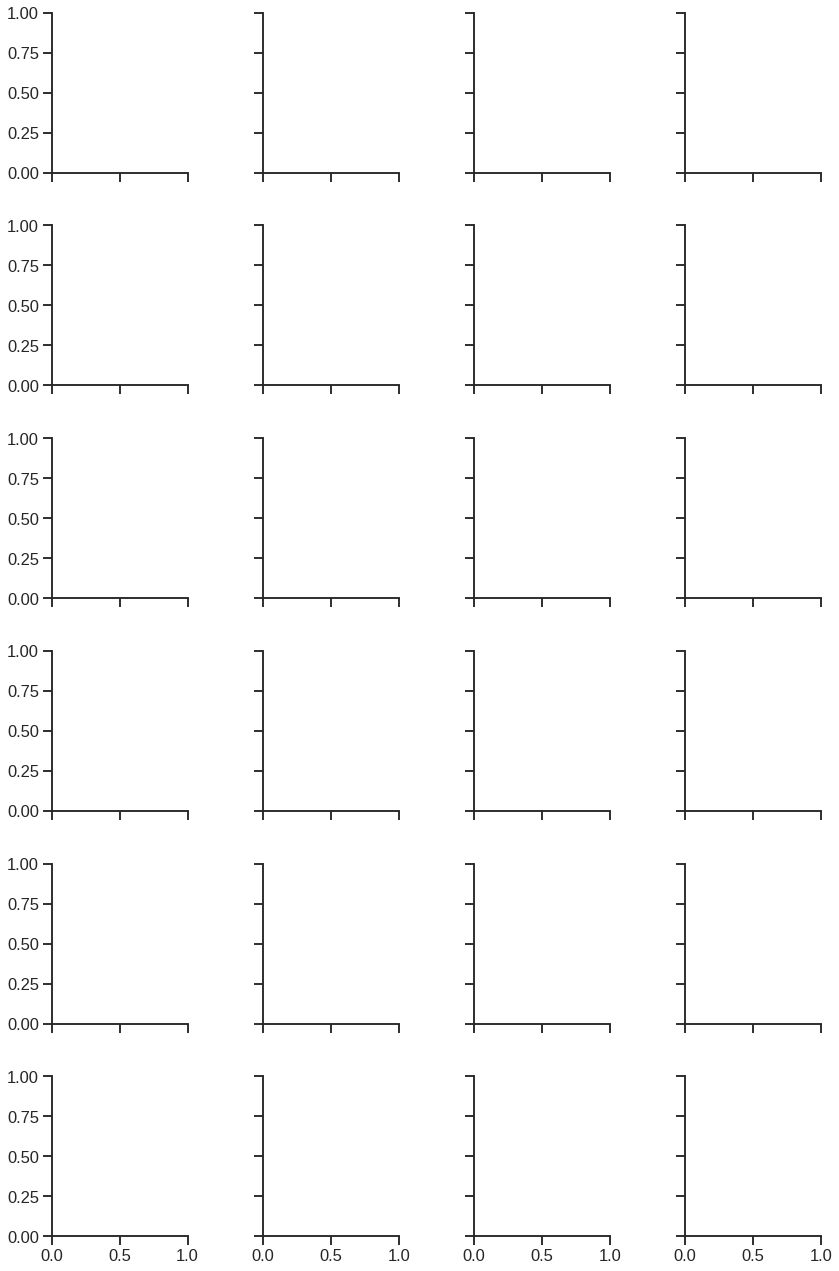

In [76]:
    
cond_plot = sns.FacetGrid(data=df_Reg, col='Gov',col_wrap=4)
cond_plot.map(sns.lineplot,'Date','lits_rea_disp', color='Darkgreen');
cond_plot.map(sns.lineplot,'Date','lits_rea_occ', color='Darkred');
cond_plot.map(sns.lineplot,'Date','lits_rea', color='Darkblue');
plt.subplots_adjust(top=0.9)
cond_plot.fig.suptitle('Evolution du nombre de lit de réanimation disponibles par gouvernerat');
cond_plot.set_xticklabels(rotation=90);
cond_plot.savefig('rea_dispo_gov.png')

### Time evolution

In [ ]:
for i in df_Reg.Gov:
    a=df_Reg[df_Reg['Gov']==i]
    fig, ax1 = plt.subplots(figsize=(15,7))
    ax1.tick_params(axis='y', labelcolor='red')

    ax1.legend(loc='upper left')
    ax1.set_ylabel('daily cases', color='red')


    ax1.plot(a.date,a.lits_rea_occ.rolling(n).mean(), color="red", label="min")

    ax1.plot(b.index,b.fittedNewDeathSMA, color="purple", label="real")


    plt.title(" Evolution temporelle du nombre des lits rea,occupés et disponibles (national)")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("nombre de DC")
    ax1.grid(axis='y')
#ax2.set_ylim(0,200)#125

    ax1.legend(loc='lower right')







    plt.grid(axis ='y')
    plt.show()




In [ ]:
cond_plot = sns.FacetGrid(data=df_Reg_10, col='Gov',col_wrap=4)
cond_plot.map(sns.lineplot,'Date','lits_rea_disp', color='Darkgreen');
cond_plot.map(sns.lineplot,'Date','lits_rea_occ', color='Darkred');
cond_plot.map(sns.lineplot,'Date','lits_rea', color='Darkblue');
plt.subplots_adjust(top=0.9)
cond_plot.set_xticklabels(rotation=90);

# Divers

In [ ]:
df_Reg.reset_index(inplace= True)

In [ ]:
Govs = df_Reg['Gov'].drop_duplicates()

def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

df_Reg_interv100_p = df_Reg[df_Reg['lits_rea'] > 100]
Govs_100_p = df_Reg_interv100_p['Gov'].drop_duplicates()
set1 = set(Govs)
set2 = set(Govs_100_p)
listGovs_100_p = set(Govs_100_p)
res_not_100_p = list(set1 - set2)

df_Reg_interv100 = df_Reg[(df_Reg['lits_rea'] <= 100) & (df_Reg['lits_rea'] > 50)]
Govs_100 = df_Reg_interv100['Gov'].drop_duplicates()
set1 = set(res_not_100_p)
set2 = set(Govs_100)
listGovs_100 = set(intersection(set1, set2))
res_not_100 = list(set1 - set2)

df_Reg_interv50 = df_Reg[(df_Reg['lits_rea'] <= 50) & (df_Reg['lits_rea'] > 25)]
Govs_50 = df_Reg_interv50['Gov'].drop_duplicates()
set1 = set(res_not_100)
set2 = set(Govs_50)
listGovs_50 = set(intersection(set1, set2))
res_not_50 = list(set1 - set2)

df_Reg_interv25 = df_Reg[(df_Reg['lits_rea'] <= 25) & (df_Reg['lits_rea'] > 10)]
Govs_25 = df_Reg_interv25['Gov'].drop_duplicates()
set1 = set(res_not_50)
set2 = set(Govs_25)
listGovs_25 = set(intersection(set1, set2))
res_not_25 = list(set1 - set2)

df_Reg_interv10 = df_Reg[df_Reg['lits_rea'] <= 10]
Govs_10 = df_Reg_interv10['Gov'].drop_duplicates()
set1 = set(res_not_25)
set2 = set(Govs_10)
listGovs_10 = set(intersection(set1, set2))


df_Reg_100_p = df_Reg[df_Reg['Gov'].isin(listGovs_100_p)]
df_Reg_100 = df_Reg[df_Reg['Gov'].isin(listGovs_100)]
df_Reg_50 = df_Reg[df_Reg['Gov'].isin(listGovs_50)]
df_Reg_25 = df_Reg[df_Reg['Gov'].isin(listGovs_25)]
df_Reg_10 = df_Reg[df_Reg['Gov'].isin(listGovs_10)]

#NOT en cas de necessite de drop
#not_df_Reg_100_p = df_Reg[~df_Reg['Gov'].isin(listGovs_100_p)]

df_Reg_10.Gov

In [ ]:
cond_plot = sns.FacetGrid(data=df_Reg_25, col='Gov',col_wrap=4)
cond_plot.map(sns.lineplot,'Date','lits_rea_disp', color='Darkgreen');
cond_plot.map(sns.lineplot,'Date','lits_rea_occ', color='Darkred');
cond_plot.map(sns.lineplot,'Date','lits_rea', color='Darkblue');
plt.subplots_adjust(top=0.9)
cond_plot.fig.suptitle('Evolution du nombre de lit de réanimation disponibles par gouvernerat');
cond_plot.set_xticklabels(rotation=90);

In [ ]:
cond_plot = sns.FacetGrid(data=df_Reg_50, col='Gov',col_wrap=4)
cond_plot.map(sns.lineplot,'Date','lits_rea_disp', color='Darkgreen');
cond_plot.map(sns.lineplot,'Date','lits_rea_occ', color='Darkred');
cond_plot.map(sns.lineplot,'Date','lits_rea', color='Darkblue');
plt.subplots_adjust(top=0.9)
cond_plot.set_xticklabels(rotation=90);

In [ ]:
cond_plot = sns.FacetGrid(data=df_Reg_100, col='Gov',col_wrap=4)
cond_plot.map(sns.lineplot,'Date','lits_rea_disp', color='Darkgreen');
cond_plot.map(sns.lineplot,'Date','lits_rea_occ', color='Darkred');
cond_plot.map(sns.lineplot,'Date','lits_rea', color='Darkblue');
plt.subplots_adjust(top=0.9)
cond_plot.set_xticklabels(rotation=90);

In [ ]:
cond_plot = sns.FacetGrid(data=df_Reg_100_p, col='Gov',col_wrap=4)
cond_plot.map(sns.lineplot,'Date','lits_rea_disp', color='Darkgreen');
cond_plot.map(sns.lineplot,'Date','lits_rea_occ', color='Darkred');
cond_plot.map(sns.lineplot,'Date','lits_rea', color='Darkblue');
plt.subplots_adjust(top=0.9)
cond_plot.set_xticklabels(rotation=90);